<a href="https://colab.research.google.com/github/akshay-chauhan-1810/Project-/blob/main/project_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tarfile
import random

from glob import glob
import librosa.display
import librosa
import os
import IPython.display as ipd

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# # Download the train-clean-100 subset (approx 6GB)
# LIBRISPEECH_URL = "https://www.openslr.org/resources/12/train-clean-100.tar.gz"
# !wget {LIBRISPEECH_URL}

--2025-06-27 13:07:15--  https://www.openslr.org/resources/12/train-clean-100.tar.gz
Resolving www.openslr.org (www.openslr.org)... 46.101.158.64
Connecting to www.openslr.org (www.openslr.org)|46.101.158.64|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://openslr.elda.org/resources/12/train-clean-100.tar.gz [following]
--2025-06-27 13:07:16--  https://openslr.elda.org/resources/12/train-clean-100.tar.gz
Resolving openslr.elda.org (openslr.elda.org)... 141.94.109.138, 2001:41d0:203:ad8a::
Connecting to openslr.elda.org (openslr.elda.org)|141.94.109.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6387309499 (5.9G) [application/x-gzip]
Saving to: ‘train-clean-100.tar.gz’

train-clean-100.tar 100%[===================>]   5.95G  32.9MB/s    in 3m 15s  

2025-06-27 13:10:32 (31.2 MB/s) - ‘train-clean-100.tar.gz’ saved [6387309499/6387309499]



In [6]:
  # Extract the files (this may take several minutes)
with tarfile.open('/content/drive/MyDrive/train-clean-100.tar.gz', 'r:gz') as tar:
    tar.extractall()

In [8]:
# Verify the download structure
# !ls LibriSpeech/train-clean-100/
print("\nNumber of speaker directories:", len(os.listdir("/content/LibriSpeech/train-clean-100/")))


Number of speaker directories: 251


In [33]:
# make searchable path for audio using glob
audio_files = glob('/content/LibriSpeech/train-clean-100/*/*/*.flac')

In [10]:
# Count number of total audio files
total_audiofile = len(audio_files)
print(f'Total number of audio files: {total_audiofile}')

Total number of audio files: 28539


In [11]:
# Group by speaker ID
speaker_data = {}
for audio_file in audio_files:
    # Get the filename from the full path
    filename = os.path.basename(audio_file)
    # Remove the extension and split the filename
    parts = os.path.splitext(filename)[0].split('-')
    speaker_id = parts[0]
    if speaker_id not in speaker_data:
        speaker_data[speaker_id] = []
    speaker_data[speaker_id].append(str(audio_file))

In [12]:
# Filter speakers with sufficient utterances
min_utterances = 5
speaker_data = {spk: files for spk, files in speaker_data.items() if len(files) >= min_utterances}
print(f"Loaded {len(speaker_data)} speakers with at least {min_utterances} utterances")

Loaded 251 speakers with at least 5 utterances


In [13]:
# 2. Create verification pairs
print("Creating 200 verification pairs...")
pairs_data = []
speakers = list(speaker_data.keys())

ratio = 0.5

# Same speaker pairs
num_same = int(200 * ratio)
for _ in range(num_same):
    speaker = random.choice([s for s in speakers if len(speaker_data[s]) >= 2])
    audio1, audio2 = random.sample(speaker_data[speaker], 2)
    pairs_data.append({
        'audio_path_1': audio1,
        'audio_path_2': audio2,
        'speaker_1': speaker,
        'speaker_2': speaker,
        'label': 1
    })


# Different speaker pairs
num_diff = 200 - num_same
for _ in range(num_diff):
    speaker1, speaker2 = random.sample(speakers, 2)
    audio1 = random.choice(speaker_data[speaker1])
    audio2 = random.choice(speaker_data[speaker2])
    pairs_data.append({
        'audio_path_1': audio1,
        'audio_path_2': audio2,
        'speaker_1': speaker1,
        'speaker_2': speaker2,
        'label': 0
    })

Creating 200 verification pairs...


In [14]:
df = pd.DataFrame(pairs_data)

# saving the dataframe
df.to_csv('audio.csv', index=False)

In [15]:
# Shuffle and create DataFrame
random.shuffle(pairs_data)
df = pd.DataFrame(pairs_data)
print(f"Created {len(df)} pairs ({num_same} same, {num_diff} different)")

Created 200 pairs (100 same, 100 different)


In [16]:
df.head()

,audio_path_1,audio_path_2,speaker_1,speaker_2,label
0,/content/LibriSpeech/train-clean-100/3168/1735...,/content/LibriSpeech/train-clean-100/3168/1735...,3168,3168,1
1,/content/LibriSpeech/train-clean-100/5393/1921...,/content/LibriSpeech/train-clean-100/83/3054/8...,5393,83,0
2,/content/LibriSpeech/train-clean-100/8014/2803...,/content/LibriSpeech/train-clean-100/4362/1566...,8014,4362,0
3,/content/LibriSpeech/train-clean-100/248/13064...,/content/LibriSpeech/train-clean-100/226/13153...,248,226,0
4,/content/LibriSpeech/train-clean-100/4160/1154...,/content/LibriSpeech/train-clean-100/2002/1394...,4160,2002,0


In [17]:
df['label'].value_counts()

,count
label,
1,100
0,100


In [14]:
# Play one audio file from dataframe
ipd.Audio(df['audio_path_1'].iloc[0])

In [15]:
df.isna().sum()

,0
audio_path_1,0
audio_path_2,0
speaker_1,0
speaker_2,0
label,0


In [16]:
samples, sample_rate = librosa.load(df['audio_path_1'].iloc[0])
print(f'samples: {samples[:50]}')
# print(f'anotehr samples: {samples[30000:30050]}')
print(f'shape of samples: {samples.shape}')
print(f'sample_rate: {sample_rate}')

samples: [-0.0006247   0.0016573   0.00366552  0.00403214  0.00337372  0.00152353
  0.00038241  0.00137952  0.00150045 -0.0003666  -0.00160062 -0.00177619
 -0.00175206 -0.00141393 -0.00174089 -0.00320278 -0.0039143  -0.00331821
 -0.00397007 -0.00700367 -0.00931774 -0.00817243 -0.00453935 -0.0001046
  0.00312972  0.00229532 -0.00136811 -0.00325168 -0.00292741 -0.00315417
 -0.00424032 -0.00476803 -0.00395507 -0.00187772  0.00071258  0.00263407
  0.00279327  0.00196233  0.00194818  0.00182257  0.00031061 -0.00077853
 -0.00069876 -0.00020655  0.0018111   0.00472288  0.0055668   0.00424586
  0.00252753  0.00179403]
shape of samples: (127890,)
sample_rate: 22050


In [17]:
# Find the exact lenght of audio
len(samples)/sample_rate

5.8

In [ ]:
# Audio Waveform
# time = np.linspace(0, len(samples)/sample_rate, len(samples))
# plt.plot(time, samples)
# plt.xlabel('Time (s)')
# plt.ylabel('Amplitude')
# plt.title('Audio Waveform')
# plt.show()

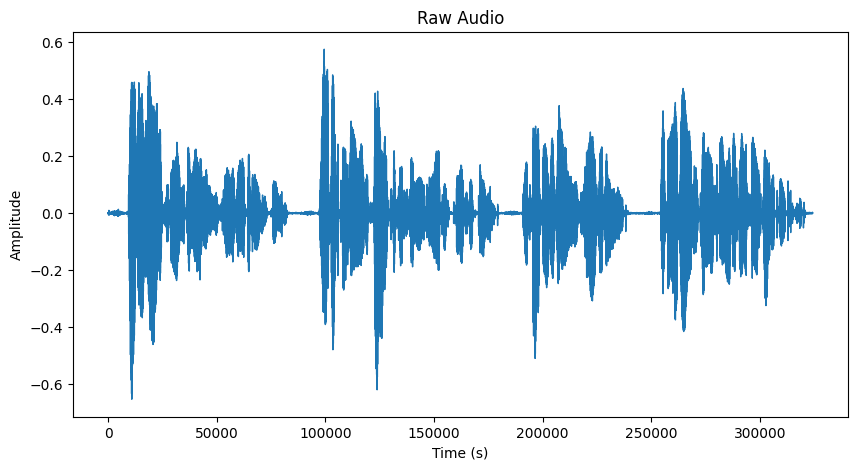

In [ ]:
# Raw Audio
pd.Series(samples).plot(figsize=(10, 5),
                        lw=1,
                        title='Raw Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

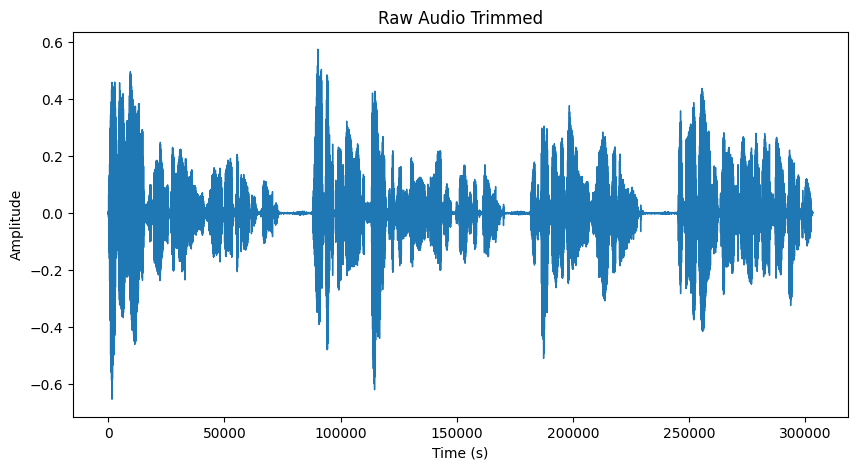

In [ ]:
# Trimming leading/lagging silence
samples_trimmed, _ = librosa.effects.trim(samples, top_db=20)
pd.Series(samples_trimmed).plot(figsize=(10, 5),
                                lw=1,
                                title='Raw Audio Trimmed')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

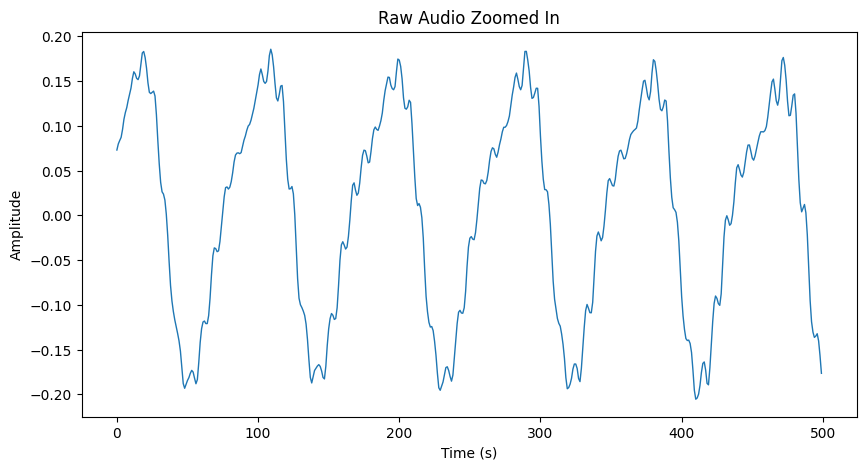

In [ ]:
# Raw Audio Zoomed in
pd.Series(samples[30000:30500]).plot(figsize=(10, 5),
                                     lw=1,
                                     title='Raw Audio Zoomed In')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

In [ ]:
# Collect all transcript files
transcript_files = glob(os.path.join('/content/LibriSpeech/train-clean-100', '*/*/*.trans.txt'))
print(transcript_files[0])

/content/LibriSpeech/train-clean-100/2002/139469/2002-139469.trans.txt


In [ ]:
# Created dataframe with transcript of auido file
data = []
for file in transcript_files:
    with open(file, 'r') as f:
        for line in f:
            parts = line.strip().split(' ', 1)
            file_id = parts[0]
            transcript = parts[1]
            speaker_id = file.split('/')[-3]
            chapter_id = file.split('/')[-2]
            flac_path = os.path.join(os.path.dirname(file), f"{file_id}.flac")
            data.append((file_id, speaker_id, chapter_id, flac_path, transcript))

df_sample = pd.DataFrame(data, columns=['file_id', 'speaker_id', 'chapter_id', 'flac_path', 'transcript'])

In [ ]:
# df_sample.head()

In [ ]:
def extract_metadata(path):
  parts = path.split('/')
  return {
      'speaker_id': parts[-3],
      'chapter_id': parts[-2],
      'utterance_id': parts[-1].split('.')[0].split('-')[-1],
      'transcript' : parts[1],
      'path': path
  }

metadata = [extract_metadata(path) for path in audio_files]
metadata_df = pd.DataFrame(metadata)

# Convert ID to numeric
metadata_df['speaker_id'] = pd.to_numeric(metadata_df['speaker_id'])
metadata_df['chapter_id'] = pd.to_numeric(metadata_df['chapter_id'])
metadata_df['utterance_id'] = pd.to_numeric(metadata_df['utterance_id'])


In [ ]:
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28539 entries, 0 to 28538
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   speaker_id    28539 non-null  int64 
 1   chapter_id    28539 non-null  int64 
 2   utterance_id  28539 non-null  int64 
 3   path          28539 non-null  object
dtypes: int64(3), object(1)
memory usage: 892.0+ KB


In [ ]:
metadata_df.isna().sum()

,0
speaker_id,0
chapter_id,0
utterance_id,0
path,0


In [ ]:
metadata_df.head()

,speaker_id,chapter_id,utterance_id,path
0,2002,139469,69,/content/LibriSpeech/train-clean-100/2002/1394...
1,2002,139469,18,/content/LibriSpeech/train-clean-100/2002/1394...
2,2002,139469,64,/content/LibriSpeech/train-clean-100/2002/1394...
3,2002,139469,4,/content/LibriSpeech/train-clean-100/2002/1394...
4,2002,139469,62,/content/LibriSpeech/train-clean-100/2002/1394...


In [ ]:
metadata_df.describe()

,speaker_id,chapter_id,utterance_id
count,28539.000000,28539.000000,28539.000000
mean,3807.547216,116990.727776,29.114860
std,2780.342240,82998.820066,23.198393
min,19.000000,198.000000,0.000000
25%,1116.000000,41615.000000,12.000000
50%,3664.000000,123523.000000,24.000000
75%,6181.000000,152139.000000,40.000000
max,8975.000000,305213.000000,132.000000


## **Speaker Distribution**

Number of unique speakers: 251


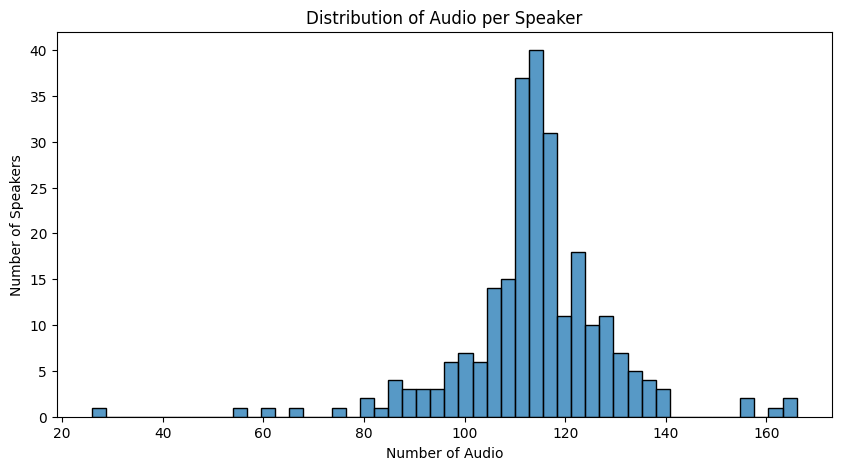

In [ ]:
# Number of unique speakers
num_speakers = metadata_df['speaker_id'].nunique()
print(f'Number of unique speakers: {num_speakers}')

# Distribution of audio per speaker id
audio_per_speaker = metadata_df['speaker_id'].value_counts()
# print(audio_per_speaker)

plt.figure(figsize=(10, 5))
sns.histplot(audio_per_speaker, bins=50)
plt.title('Distribution of Audio per Speaker')
plt.xlabel('Number of Audio')
plt.ylabel('Number of Speakers')
plt.show()

## **Audio** **Duration** **Analysis**

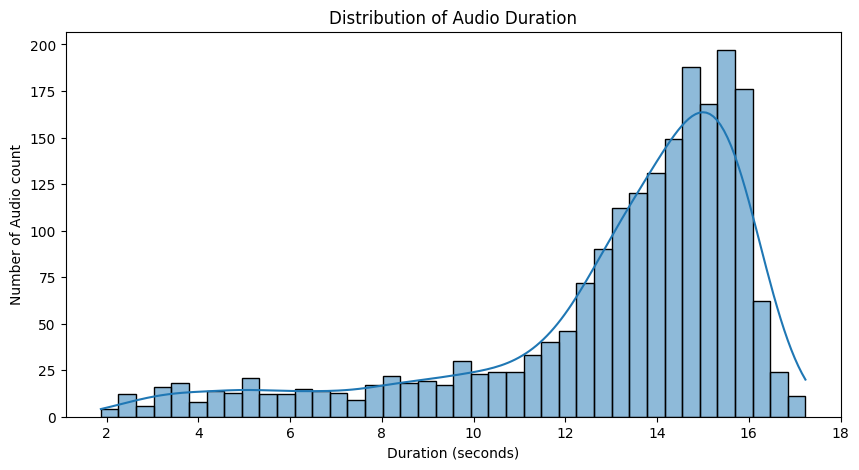

In [18]:
duration = []
# Sample first 500 files to get duration
for f in audio_files[:2000]:
  y, sr = librosa.load(f, sr=None)
  duration.append(len(y)/sr)

plt.figure(figsize=(10, 5))
sns.histplot(duration, bins=40, kde=True)
plt.title('Distribution of Audio Duration')
plt.xlabel('Duration (seconds)')
plt.ylabel('Number of Audio count')
plt.show()

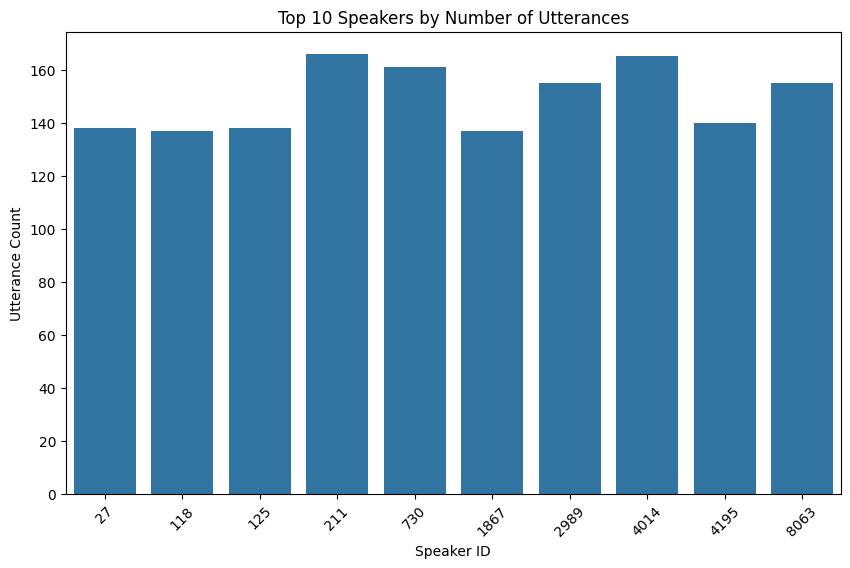

In [ ]:
# Plot Top 10 Speakers by Utterance Count
top_speakers = metadata_df['speaker_id'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_speakers.index, y=top_speakers.values)
plt.title("Top 10 Speakers by Number of Utterances")
plt.xlabel("Speaker ID")
plt.ylabel("Utterance Count")
plt.xticks(rotation=45)
plt.show()

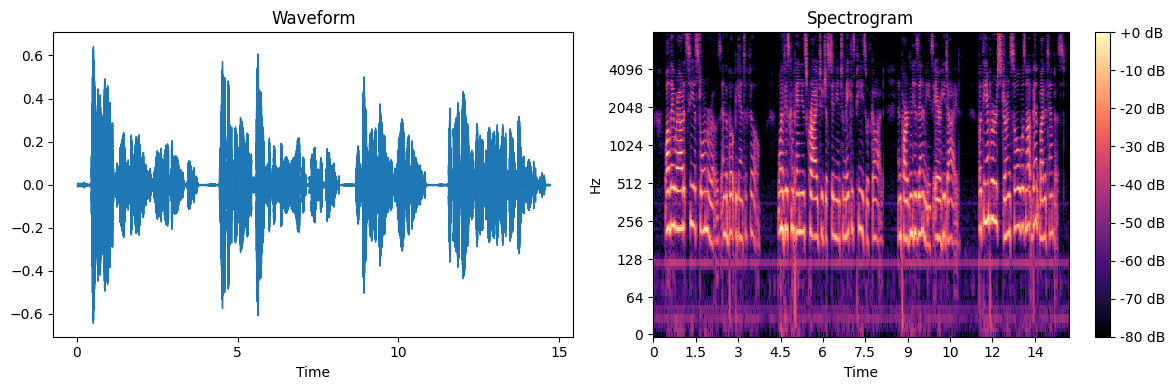

In [ ]:
# Waveform and Spectrogram Visualization

# path = '/content/LibriSpeech/train-clean-100/*/*/*.flac'

def plot_waveform_spectrogram(path):
    y, sr = librosa.load(path, sr=None)
    plt.figure(figsize=(12, 4))

    # Waveform
    plt.subplot(1, 2, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title("Waveform")


    # Spectrogram
    plt.subplot(1, 2, 2)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format="%+2.0f dB")
    plt.title("Spectrogram")

    plt.tight_layout()
    plt.show()

# Visualize one sample
# plot_waveform_spectrogram(df_sample['flac_path'].iloc[0])
# plot_waveform_spectrogram(audio_files[0])
plot_waveform_spectrogram(df['audio_path_1'].loc[0])


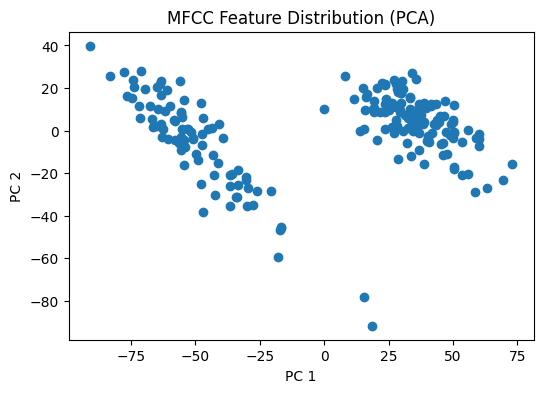

In [ ]:
# From metadata dataframe
def extract_features(path):
    y, sr = librosa.load(path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    return mfcc.mean(axis=1)

# Extract MFCCs for first 200 samples
mfcc_features = metadata_df['path'].iloc[:200].apply(extract_features)

# Stack MFCCs into a matrix
mfcc_matrix = np.vstack(mfcc_features.values)


# PCA to 2D
from sklearn.decomposition import PCA
X_pca = PCA(n_components=2).fit_transform(mfcc_matrix)

plt.figure(figsize=(6,4))
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.title('MFCC Feature Distribution (PCA)')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.savefig("mfcc_pca.jpg")
plt.show()

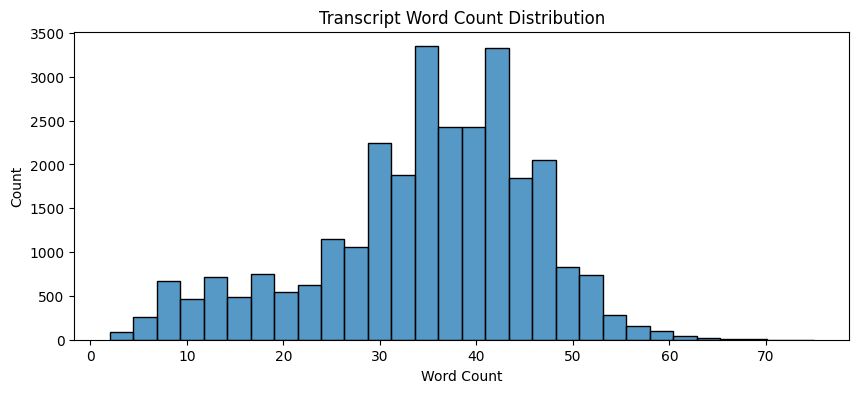

In [ ]:
# Transcript Analysis
df_sample['word_count'] = df_sample['transcript'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 4))
sns.histplot(df_sample['word_count'], bins=30)
plt.title('Transcript Word Count Distribution')
plt.xlabel('Word Count')
plt.show()

In [22]:
X_svm = df.iloc[:, :-3]
y = df['label']

In [23]:
print(X_svm.shape)
print(y.shape)

(200, 2)
(200,)


In [33]:
# Using SVM
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV


# Convert pairs to feature differences
X = []
for index, pair in df.iterrows():
    # Now 'pair' is a Pandas Series representing the row
    emb1 = extract_features(pair['audio_path_1'])
    emb2 = extract_features(pair['audio_path_2'])
    X.append(np.abs(emb1 - emb2))  # Absolute difference

    similarity = cosine_similarity([emb1], [emb2])[0][0]
    print(f"Similarity between {pair['audio_path_1']} and {pair['audio_path_2']}: {similarity}")

X = pd.DataFrame(X)

[-0.00076294  0.00268555  0.00396729 ...  0.00570679  0.00540161
  0.00015259] 16000
[ 0.0007019  -0.00064087 -0.00094604 ...  0.00021362 -0.00045776
 -0.00079346] 16000
Similarity between /content/LibriSpeech/train-clean-100/5514/19192/5514-19192-0047.flac and /content/LibriSpeech/train-clean-100/5514/19193/5514-19193-0007.flac: 0.9859561920166016
[-0.00668335 -0.00762939 -0.00738525 ... -0.00448608 -0.00460815
 -0.00473022] 16000
[-0.00018311 -0.00057983 -0.00064087 ...  0.00134277  0.0010376
  0.00088501] 16000
Similarity between /content/LibriSpeech/train-clean-100/481/123720/481-123720-0060.flac and /content/LibriSpeech/train-clean-100/3242/8112/3242-8112-0009.flac: 0.9952682256698608
[ 9.1552734e-05  2.3498535e-03  1.1901855e-03 ... -3.5705566e-03
 -1.2512207e-03 -1.4953613e-03] 16000
[-1.4343262e-03 -1.5869141e-03 -1.5258789e-03 ... -1.5258789e-04
  9.1552734e-05  8.5449219e-04] 16000
Similarity between /content/LibriSpeech/train-clean-100/311/124404/311-124404-0079.flac and /co

In [35]:
X

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,46.079010,33.895378,18.414494,3.775154,7.430536,16.351051,10.032175,15.759659,2.123231,9.618715,4.356129,0.629548,0.093098
1,15.514130,26.702835,7.513519,7.558613,1.153076,10.347139,5.631252,9.195307,2.126224,3.723184,9.136690,11.035751,2.766447
2,10.747406,24.412296,1.033470,0.648945,0.111590,2.637142,4.952984,1.279082,0.068002,0.631296,2.542081,1.557318,1.149830
3,57.101959,46.209679,1.640145,37.836517,20.103369,28.014858,14.120334,1.530584,13.808922,6.194236,11.812000,1.635576,14.907692
4,18.992920,20.853943,0.793008,5.570114,1.377395,0.556139,1.643733,4.213008,1.904100,1.740030,1.861674,5.906411,1.981968
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,17.747681,10.797585,23.966236,13.690969,12.475437,4.256142,0.408713,11.021964,2.037273,4.011495,16.761263,6.036985,1.931193
196,24.292053,25.722557,8.791584,2.204359,4.000149,9.674989,6.655879,2.781366,6.484408,2.045831,0.471855,6.968908,3.328231
197,29.300156,49.740189,43.943787,47.119987,31.106325,36.577534,4.938534,2.723955,3.737284,0.198164,5.014858,6.191090,7.102169
198,21.171722,10.300072,6.693204,0.702938,1.996068,4.213106,0.034089,11.628043,8.253972,2.805797,5.150854,1.089401,2.079768


In [ ]:
# standared_scaler = StandardScaler()
# X_scaled= standared_scaler.fit_transform(X)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = SVC(kernel="rbf")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
# print("AUC:", roc_auc_score(y_test, y_pred))

Accuracy: 0.8333333333333334
              precision    recall  f1-score   support

           0       0.92      0.75      0.83        32
           1       0.76      0.93      0.84        28

    accuracy                           0.83        60
   macro avg       0.84      0.84      0.83        60
weighted avg       0.85      0.83      0.83        60



In [43]:
# Print the Confusion Matrix and slice it into four pieces

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)

print('\nTrue Positives(TP) = ', cm[0,0])

print('\nTrue Negatives(TN) = ', cm[1,1])

print('\nFalse Positives(FP) = ', cm[0,1])

print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[24  8]
 [ 2 26]]

True Positives(TP) =  24

True Negatives(TN) =  26

False Positives(FP) =  8

False Negatives(FN) =  2


In [38]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],
			'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
			'kernel': ['rbf']}

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.536 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.536 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.500 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.500 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.500 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.536 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.536 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.500 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.500 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.500 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.536 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [39]:
print(grid.best_params_)
print(grid.best_estimator_)

{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
SVC(C=1, gamma=0.001)


In [40]:
grid_predictions = grid.predict(X_test)
print(accuracy_score(y_test, grid_predictions))
print(classification_report(y_test, grid_predictions))

0.8833333333333333
              precision    recall  f1-score   support

           0       0.88      0.91      0.89        32
           1       0.89      0.86      0.87        28

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60



In [45]:
# Print the Confusion Matrix and slice it into four pieces

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, grid_predictions)

print('Confusion matrix\n\n', cm)

print('\nTrue Positives(TP) = ', cm[0,0])

print('\nTrue Negatives(TN) = ', cm[1,1])

print('\nFalse Positives(FP) = ', cm[0,1])

print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[29  3]
 [ 4 24]]

True Positives(TP) =  29

True Negatives(TN) =  24

False Positives(FP) =  3

False Negatives(FN) =  4


In [32]:
# Feature Extraction Function
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=16000)
    print(y, sr)

    # MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs.T, axis=0)

    # # Pitch
    # pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    # pitch = pitches[magnitudes > np.median(magnitudes)].mean() if np.any(magnitudes > 0) else 0

    # # Spectral Roll-off
    # rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0].mean()


    # # Zero-Crossing Rate
    # zcr = librosa.feature.zero_crossing_rate(y)[0].mean()

    # Combine features
    # return np.hstack([mfccs_mean, pitch, rolloff, zcr])
    return mfccs_mean


### **Speech to Text**

In [ ]:
!pip install faster-whisper

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.3/35.3 MB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.6 MB/s eta 0:00:00


In [ ]:
from faster_whisper import WhisperModel
model_size = "large"

In [ ]:
model = WhisperModel(model_size, device="cpu", compute_type="int8")
segments, info = model.transcribe("/content/27-124992-0000.flac", beam_size=5)
# df_sample['flac_path'].iloc[:100].apply(extract_features)
print("Detected language '%s' with probability %f" % (info.language, info.language_probability))
for segment in segments:
    print("[%.2fs -> %.2fs] %s" % (segment.start, segment.end, segment.text))

Detected language 'en' with probability 0.999730
[0.00s -> 16.90s]  is generally believed to be the high priest eliakim called also joachim the transactions herein related most probably happened in his days and in the reign of manassas after his repentance and return from captivity


## **Speech Verification Using Pre-trained model VoiceEncoder - resemblyzer**

In [ ]:
!pip install resemblyzer

In [ ]:
from resemblyzer import preprocess_wav, VoiceEncoder

encoder = VoiceEncoder("cpu")
wav1 = preprocess_wav('/content/LibriSpeech/train-clean-100/1723/141149/1723-141149-0003.flac')
wav2 = preprocess_wav('/content/LibriSpeech/train-clean-100/1723/141149/1723-141149-0013.flac')

emd1 = encoder.embed_utterance(wav1)
emd2 = encoder.embed_utterance(wav2)

similarity = np.dot(emd1, emd2) / (np.linalg.norm(emd1) * np.linalg.norm(emd2))

print(similarity)

Loaded the voice encoder model on cpu in 0.50 seconds.
0.9500014


# **ECAPA-TDNN**

In [29]:
!pip install speechbrain

In [30]:
import speechbrain as sb
from speechbrain.pretrained import EncoderClassifier , SpeakerRecognition
import torch
import torchaudio

In [31]:
# Pretrained ECAPA model from SpeechBrain
verification = SpeakerRecognition.from_hparams(
    source="speechbrain/spkrec-ecapa-voxceleb",
    savedir="pretrained_ecapa"
)

INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/pretrained_ecapa/hyperparams.yaml'
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_ecapa/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_ecapa/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/cont

In [34]:
# Initialize ECAPA-TDNN processor
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Loading ECAPA-TDNN model...")
ecapa_model = EncoderClassifier.from_hparams(
    source="speechbrain/spkrec-ecapa-voxceleb",
    savedir="pretrained_models/spkrec-ecapa-voxceleb",
    run_opts={"device": device}
)

INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/hyperparams.yaml' -> '/content/pretrained_models/spkrec-ecapa-voxceleb/hyperparams.yaml'
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


Loading ECAPA-TDNN model...


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/embedding_model.ckpt' -> '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain-

In [49]:
# # 4. Extract embeddings
# print("Extracting embeddings...")
# embeddings_1 = []
# embeddings_2 = []
# labels = []

# for idx, row in df.iterrows():
#     # Load and preprocess audio
#     def load_audio(audio_path, sample_rate=16000, max_length=4.0):
#         audio, sr = librosa.load(audio_path, sr=sample_rate)
#         audio, _ = librosa.effects.trim(audio, top_db=20)
#         min_samples = int(0.5 * sample_rate)
#         if len(audio) < min_samples:
#             repeat_times = int(np.ceil(min_samples / len(audio)))
#             audio = np.tile(audio, repeat_times)[:min_samples]
#         max_samples = int(max_length * sample_rate)
#         if len(audio) > max_samples:
#             start_idx = random.randint(0, len(audio) - max_samples)
#             audio = audio[start_idx:start_idx + max_samples]
#         audio = audio / (np.max(np.abs(audio)) + 1e-7)
#         return torch.FloatTensor(audio).unsqueeze(0)

Extracting embeddings...


In [35]:
# 4. Audio processing and embedding extraction
def load_audio(audio_path, sample_rate=16000, max_length=3.0):
    """Load and preprocess audio file"""
    audio, sr = librosa.load(audio_path, sr=sample_rate)
    audio, _ = librosa.effects.trim(audio, top_db=20)

    # Ensure minimum length
    if len(audio) < int(0.5 * sample_rate):
        repeat = int(np.ceil(int(0.5 * sample_rate) / len(audio)))
        audio = np.tile(audio, repeat)[:int(0.5 * sample_rate)]

    # Trim to max length
    if len(audio) > int(max_length * sample_rate):
        start = random.randint(0, len(audio) - int(max_length * sample_rate))
        audio = audio[start:start + int(max_length * sample_rate)]

    # Normalize
    audio = audio / (np.max(np.abs(audio)) + 1e-7)
    return torch.FloatTensor(audio).unsqueeze(0)

def extract_embedding(audio_tensor):
    """Extract speaker embedding"""
    with torch.no_grad():
        return ecapa_model.encode_batch(audio_tensor.to(device)).cpu().numpy().squeeze()

In [ ]:
# from speechbrain.inference.speaker import SpeakerRecognition
# verification = SpeakerRecognition.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb", savedir="pretrained_models/spkrec-ecapa-voxceleb")
# score, prediction = verification.verify_files("/content/LibriSpeech/train-clean-100/103/1240/103-1240-0000.flac", "/content/LibriSpeech/train-clean-100/103/1241/103-1241-0027.flac") # Different Speakers
# print(score, prediction)
# score, prediction = verification.verify_files("/content/LibriSpeech/train-clean-100/103/1241/103-1241-0003.flac", "/content/LibriSpeech/train-clean-100/103/1241/103-1241-0025.flac") # Same Speaker
# print(score, prediction)

In [52]:
# This model is pre-trained on VoxCeleb and is excellent for extracting speaker embeddings.
print("Loading pre-trained ECAPA-TDNN model from SpeechBrain Hub...")
try:
    from speechbrain.lobes.models.ECAPA_TDNN import EncoderClassifier
    classifier = EncoderClassifier.from_hparams(
        source="speechbrain/spkrec-ecapa-voxceleb",
        savedir="pretrained_models/spkrec-ecapa-voxcelebhparams.yaml" # Directory to save the downloaded model
    )
    print("ECAPA-TDNN model loaded successfully.")
except Exception as e:
    print(f"Error loading ECAPA-TDNN model: {e}")
    print("Please ensure you have an internet connection and SpeechBrain is correctly installed.")
    print("You might also need to clear 'pretrained_models/spkrec-ecapa-voxceleb' if there was a corrupt download.")
    exit()

Loading pre-trained ECAPA-TDNN model from SpeechBrain Hub...
Error loading ECAPA-TDNN model: cannot import name 'EncoderClassifier' from 'speechbrain.lobes.models.ECAPA_TDNN' (/usr/local/lib/python3.11/dist-packages/speechbrain/lobes/models/ECAPA_TDNN.py)
Please ensure you have an internet connection and SpeechBrain is correctly installed.
You might also need to clear 'pretrained_models/spkrec-ecapa-voxceleb' if there was a corrupt download.


In [ ]:
# --- 4. Inference: Extract Embeddings for SVM ---
# Instead of just similarity scores, we'll store both embeddings from each pair
# to create feature vectors for the SVM.
print("Extracting embeddings for each audio in pairs...")
pair_features = [] # Stores feature vectors for SVM
true_labels = []   # Stores the ground truth label (1 for same, 0 for different)

Extracting embeddings for each audio in pairs...


In [ ]:
from tqdm import tqdm

In [1]:
def extract_embedding1(audio_tensor):
    """Extract speaker embedding"""
    with torch.no_grad():
        return ecapa_model.encode_batch(audio_tensor.to(device)).cpu().numpy().squeeze()

In [56]:
print("Processing audio pairs and extracting embeddings...")
cosine_scores = []
labels = []

for _, pair in df.iterrows():
    # Load both audio files
    audio1 = load_audio(pair['audio_path_1'])
    audio2 = load_audio(pair['audio_path_2'])

    # Extract embeddings
    emb1 = extract_embedding1(audio1)
    emb2 = extract_embedding1(audio2)

    # Normalize embeddings
    emb1_norm = emb1 / np.linalg.norm(emb1)
    emb2_norm = emb2 / np.linalg.norm(emb2)

    # Compute cosine similarity
    cosine_score = np.dot(emb1_norm, emb2_norm)
    cosine_scores.append(cosine_score)
    labels.append(pair['label'])

# Convert to numpy arrays
cosine_scores = np.array(cosine_scores)
labels = np.array(labels)


Processing audio pairs and extracting embeddings...


In [57]:
# prompt: import roc curve

from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score

# 4. Split data (maintain speaker independence)
print("Splitting data into train/test sets...")
speaker_ids = df['speaker_1'].values  # For speaker-independent split

# Split indices to keep pairs together
train_idx, test_idx = train_test_split(
    np.arange(len(df)),
    test_size=0.2,
    random_state=42,
    stratify=labels,
    shuffle=True
)

Splitting data into train/test sets...


In [58]:
# Split scores and labels
train_scores = cosine_scores[train_idx]
test_scores = cosine_scores[test_idx]
train_labels = labels[train_idx]
test_labels = labels[test_idx]

# 5. Find optimal threshold on training set
print("Finding optimal threshold...")
fpr, tpr, thresholds = roc_curve(train_labels, train_scores)
optimal_idx = np.argmax(tpr - fpr)
optimal_fpr = fpr[optimal_idx]
optimal_tpr = tpr[optimal_idx]
optimal_threshold = thresholds[optimal_idx]


Finding optimal threshold...


In [ ]:
# import matplotlib.pyplot as plt
# import sklearn.metrics # Import the sklearn.metrics module

# plt.figure(figsize=(6, 4))
# # Use sklearn.metrics.auc explicitly to avoid name collision
# plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % sklearn.metrics.auc(fpr, tpr))
# plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
# plt.plot([optimal_fpr], [optimal_tpr], 'ro', label='Optimal threshold')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.legend(loc='lower right')
# plt.show()

In [59]:
# 6. Evaluate on test set
test_pred = (test_scores > optimal_threshold).astype(int)
accuracy = accuracy_score(test_labels, test_pred)
auc = roc_auc_score(test_labels, test_scores)

print("\nECAPA-TDNN Verification Results:")
print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test AUC: {auc:.4f}")


ECAPA-TDNN Verification Results:
Optimal Threshold: 0.3258
Test Accuracy: 1.0000
Test AUC: 1.0000


In [60]:
# 7. (Optional) Save results
results = pd.DataFrame({
    'audio_path_1': df.iloc[test_idx]['audio_path_1'],
    'audio_path_2': df.iloc[test_idx]['audio_path_2'],
    'cosine_score': test_scores,
    'prediction': test_pred,
    'true_label': test_labels
})
results.to_csv('ecapa_verification_results.csv', index=False)

In [61]:
results

,audio_path_1,audio_path_2,cosine_score,prediction,true_label
73,/content/LibriSpeech/train-clean-100/7067/7604...,/content/LibriSpeech/train-clean-100/7264/9231...,-0.088368,0,0
85,/content/LibriSpeech/train-clean-100/5393/1921...,/content/LibriSpeech/train-clean-100/5393/1921...,0.490279,1,1
187,/content/LibriSpeech/train-clean-100/8088/2847...,/content/LibriSpeech/train-clean-100/8088/2847...,0.690293,1,1
189,/content/LibriSpeech/train-clean-100/2289/1522...,/content/LibriSpeech/train-clean-100/2289/1522...,0.599484,1,1
42,/content/LibriSpeech/train-clean-100/4362/1566...,/content/LibriSpeech/train-clean-100/2910/1310...,0.099256,0,0
12,/content/LibriSpeech/train-clean-100/5789/5719...,/content/LibriSpeech/train-clean-100/5789/7065...,0.647272,1,1
62,/content/LibriSpeech/train-clean-100/4214/7146...,/content/LibriSpeech/train-clean-100/26/495/26...,0.012251,0,0
164,/content/LibriSpeech/train-clean-100/3526/1766...,/content/LibriSpeech/train-clean-100/3526/1766...,0.612219,1,1
128,/content/LibriSpeech/train-clean-100/625/13211...,/content/LibriSpeech/train-clean-100/625/13211...,0.592075,1,1
174,/content/LibriSpeech/train-clean-100/7312/9243...,/content/LibriSpeech/train-clean-100/2182/1811...,0.136257,0,0


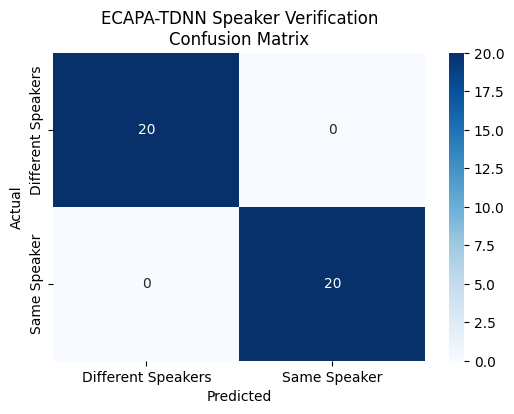


Classification Report:
                    precision    recall  f1-score   support

Different Speakers       1.00      1.00      1.00        20
      Same Speaker       1.00      1.00      1.00        20

          accuracy                           1.00        40
         macro avg       1.00      1.00      1.00        40
      weighted avg       1.00      1.00      1.00        40



In [62]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions using optimal threshold
test_pred = (test_scores > optimal_threshold).astype(int)

# Create confusion matrix
cm = confusion_matrix(test_labels, test_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Different Speakers', 'Same Speaker'],
            yticklabels=['Different Speakers', 'Same Speaker'])
plt.title('ECAPA-TDNN Speaker Verification\nConfusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Print classification report
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(test_labels, test_pred,
                           target_names=['Different Speakers', 'Same Speaker']))

In [36]:
print("Processing audio pairs and extracting embeddings...")
features = []
labels = []

for _, pair in df.iterrows():
    # Load both audio files
    audio1 = load_audio(pair['audio_path_1'])
    audio2 = load_audio(pair['audio_path_2'])

    # Extract embeddings
    emb1 = extract_embedding1(audio1)
    emb2 = extract_embedding1(audio2)


    # Normalize embeddings
    emb1_norm = emb1 / np.linalg.norm(emb1)
    emb2_norm = emb2 / np.linalg.norm(emb2)

    features.append(np.abs(emb1_norm - emb2_norm))
    labels.append(pair['label'])

# Convert to numpy arrays
X1 = np.array(features)
y1 = np.array(labels)


Processing audio pairs and extracting embeddings...


In [39]:
X1.shape

(200, 192)

In [42]:
y1.shape

(200,)

(160, 192) (40, 192) (160,) (40,)
Classification Report:
                    precision    recall  f1-score   support

Different Speakers       1.00      0.95      0.97        20
      Same Speaker       0.95      1.00      0.98        20

          accuracy                           0.97        40
         macro avg       0.98      0.97      0.97        40
      weighted avg       0.98      0.97      0.97        40



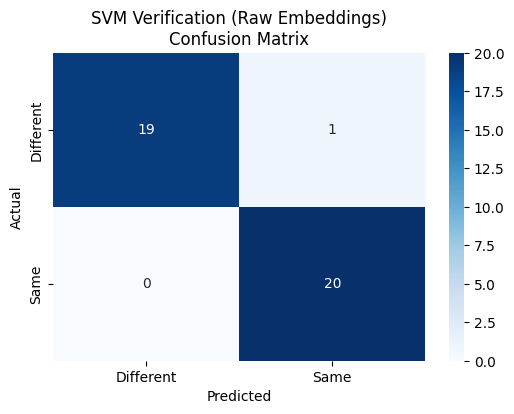

In [49]:
# perfomr SVM
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# 3. Train-test split (speaker-independent)
X_train, X_test, y_train, y_test = train_test_split(
    X1, y1,
    test_size=0.2,
    random_state=42,
    stratify=y1
)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# 4. Create SVM pipeline with feature scaling
model = make_pipeline(
    SVC(
        kernel='linear',
        C=1.0,
        gamma='scale',
        probability=True,
        random_state=42
    )
)

# 5. Train SVM
model.fit(X_train, y_train)

# 6. Evaluate
y_pred = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred,
                          target_names=['Different Speakers', 'Same Speaker']))

# 7. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Different', 'Same'],
            yticklabels=['Different', 'Same'])
plt.title('SVM Verification (Raw Embeddings)\nConfusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [55]:
# ---- Verification Function ----
def verify_speakers(audio_path1, audio_path2, model):
    # Load and embed both audios
    audio1 = load_audio(audio_path1)
    audio2 = load_audio(audio_path2)

    emb1 = extract_embedding1(audio1)
    emb2 = extract_embedding1(audio2)

    # Normalize
    emb1_norm = emb1 / (np.linalg.norm(emb1) + 1e-10)
    emb2_norm = emb2 / (np.linalg.norm(emb2) + 1e-10)

    # Create feature (absolute difference)
    feat = np.abs(emb1_norm - emb2_norm).reshape(1, -1)

    # Predict using the pipeline (includes scaling)
    pred = model.predict(feat)[0]
    prob = model.predict_proba(feat)[0][1]  # probability of same speaker (label 1)

    return pred, prob


# Replace with your actual file paths
audio_path1 = "/content/LibriSpeech/train-clean-100/1098/133695/1098-133695-0089.flac"
audio_path2 = "/content/LibriSpeech/train-clean-100/1098/133695/1098-133695-0001.flac"

# Make sure the `model` variable is your trained SVM pipeline
# model = make_pipeline(StandardScaler(), SVC(...))  # already trained earlier

pred, prob = verify_speakers(audio_path1, audio_path2, model)

if pred == 1:
    print(f"Same speaker (confidence: {prob:.2f})")
else:
    print(f"Different speakers (confidence: {prob:.2f})")


Same speaker (confidence: 0.99)


## **speaker identity with a PCA**

In [25]:
# from speechbrain.inference.speaker import SpeakerRecognition
# import torchaudio
# verification = SpeakerRecognition.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb", savedir="./pretrained_ecapa")
signal, fs = torchaudio.load('/content/LibriSpeech/train-clean-100/1034/121119/1034-121119-0000.flac')
embedding = verification.encode_batch(signal)
embedding.shape

torch.Size([1, 1, 192])

In [ ]:
utterances = glob("/content/LibriSpeech/train-clean-100/**/*.flac", recursive=True)
np.random.shuffle(utterances)
utterances = utterances[:20]

from pathlib import Path

embeddings = []
labels = []
for u in utterances:
    tmp, fs = torchaudio.load(u)
    e = verification.encode_batch(tmp)
    embeddings.append(e[0, 0].numpy())
    spk_label = Path(u).parent.parent.stem
    labels.append(spk_label)

In [ ]:
from sklearn.decomposition import PCA

embeddings = np.array(embeddings)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(embeddings)

Text(0, 0.5, 'Principal Component 2')

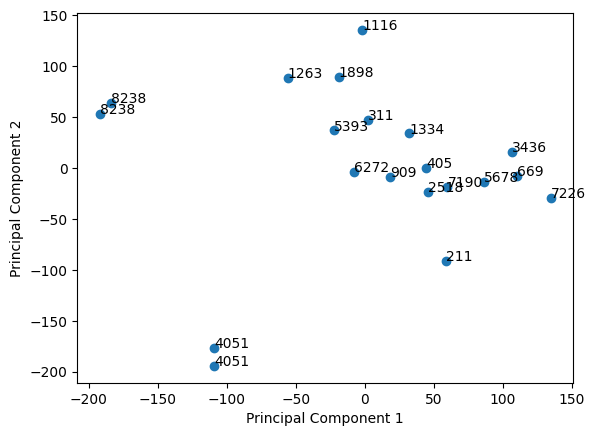

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(principalComponents[:, 0], principalComponents[:, 1])

for i, spkid in enumerate(labels):
    ax.annotate(spkid, (principalComponents[i, 0], principalComponents[i, 1]))
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

In [24]:
# Function to extract embeddings
def get_embedding(file_path):
    signal, sr = torchaudio.load(file_path)
    signal = signal.mean(dim=0, keepdim=True)  # Mono
    embedding = verification.encode_batch(signal)
    return embedding.squeeze().detach().numpy()
